# XGBoost Training Notebook For Jane Street Real-Time Market Data Forecasting

In [1]:
import os
import joblib 

import pandas as pd
import polars as pl
import numpy as np

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.metrics import r2_score

import optuna

import pickle

from joblib import Parallel, delayed

import kaggle_evaluation.jane_street_inference_server

In [2]:
target="responder_6"
start_date_id = 1448 #use last 250 days
lags_cols = ["date_id", "symbol_id"] + [f"responder_{idx}" for idx in range(9)]
validation_ratio=0.05
features = ["symbol_id", "time_id"] + [f"feature_{idx:02d}" for idx in range(79)] + [f"responder_{idx}_lag_1" for idx in range(9)]
SEED=42

In [3]:
train = pl.scan_parquet(
    f"/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"
).select(
    pl.int_range(pl.len(), dtype=pl.UInt32).alias("id"),
    pl.all(),
).with_columns(
    (pl.col(target)*2).cast(pl.Int32).alias("label"),
).filter(
    pl.col("date_id").gt(start_date_id)
)

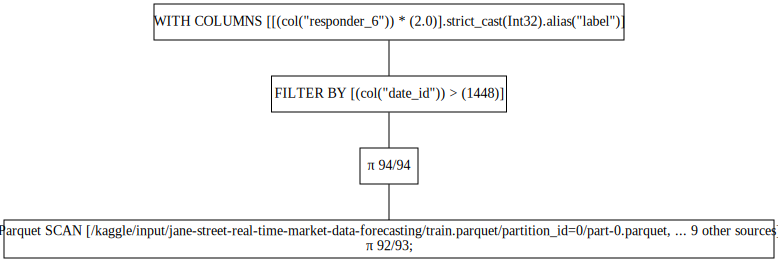

In [4]:
train.show_graph()

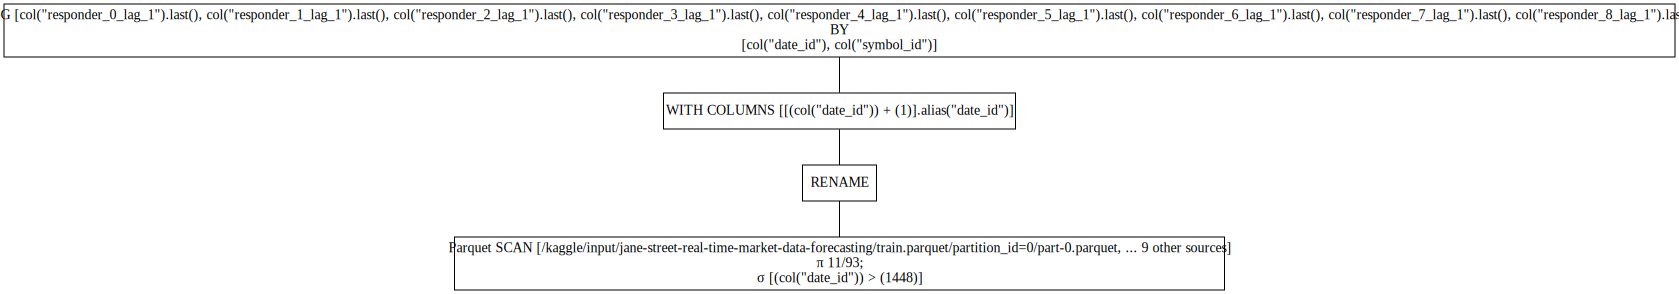

In [5]:
lags = train.select(pl.col(lags_cols))
lags_cols_rename = { f"responder_{idx}" : f"responder_{idx}_lag_1" for idx in range(9)}
lags = lags.rename(lags_cols_rename)
lags = lags.with_columns(
    date_id = pl.col('date_id') + 1,  # 1 day lag
    )
lags = lags.group_by(["date_id", "symbol_id"], maintain_order=True).last()  # pick up last record of previous date
lags.show_graph()

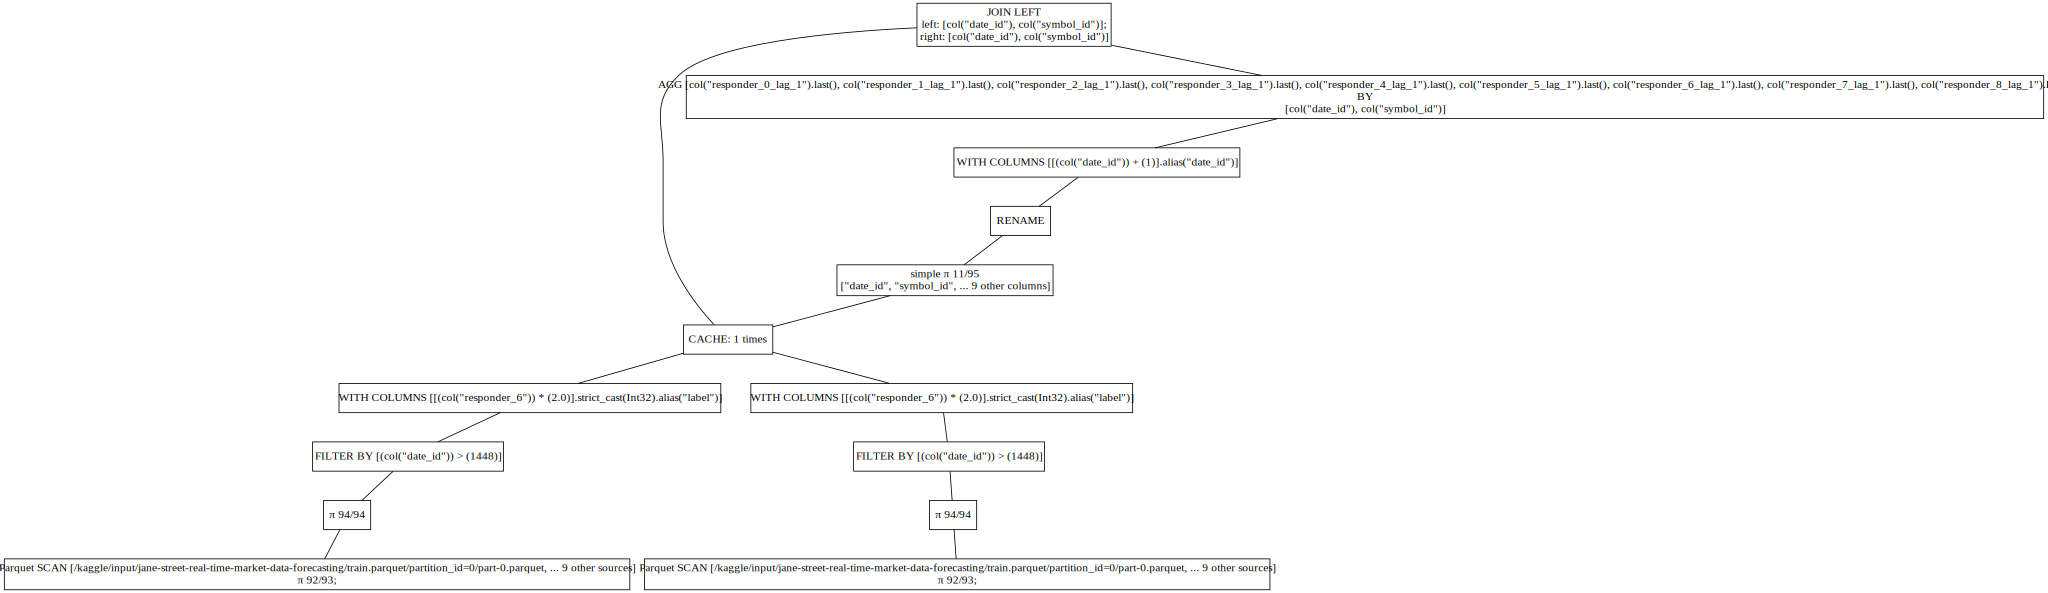

In [6]:
train = train.join(lags, on=["date_id", "symbol_id"],  how="left")
train.show_graph()

In [7]:
len_set   = train.select(pl.col("date_id")).collect().shape[0]
len_validation = int(len_set * validation_ratio)
len_train = len_set - len_validation
last_train_date  = train.select(pl.col("date_id")).collect().row(len_train)[0]

print(f"{len_set=}")
print(f"{len_train=}")
print(f"Last offline train date = {last_train_date}\n")

training_data = train.filter(pl.col("date_id").le(last_train_date)).collect()
validation_data = train.filter(pl.col("date_id").gt(last_train_date)).collect()

len_set=9217296
len_train=8756432
Last offline train date = 1686



In [8]:
X_train = training_data[features]
y_train = training_data[target]
w_train = training_data["weight"]
X_val = validation_data[features ]
y_val = validation_data[target ]
w_val = validation_data["weight"]
X_train.shape, y_train.shape, w_train.shape, X_val.shape, y_val.shape, w_val.shape

((8765240, 90), (8765240,), (8765240,), (452056, 90), (452056,), (452056,))

In [9]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 200,
        "verbosity": 0,
        'tree_method': 'gpu_hist',
        'device' : 'cuda',
        'n_gpus' : 2,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    score = r2_score(y_val, predictions, sample_weight=w_val)
    return score

In [10]:
OPTUNA=False

if OPTUNA:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

In [11]:
XGB_Params = {
        'learning_rate': 0.05,
        'max_depth': 6,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1,
        'reg_lambda': 5,
        'random_state': SEED,
        'tree_method': 'gpu_hist',
        'device' : 'cuda',
        'n_gpus' : 2,
    }

In [12]:
%%time
model = XGBRegressor(**XGB_Params)
model.fit( X_train, y_train, sample_weight=w_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:14:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:14:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 1min 25s, sys: 8.82 s, total: 1min 34s
Wall time: 1min 12s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_gpus=2, n_jobs=None,
             num_parallel_tree=None, ...)

In [13]:
y_pred=model.predict(X_train)
train_score = r2_score(y_train, y_pred, sample_weight=w_train)
train_score

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:15:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


0.05998816923418093

In [14]:
y_pred=model.predict(X_val)
val_score = r2_score(y_val, y_pred, sample_weight=w_val)
val_score

0.0030272336836630886

In [15]:
final_params=XGB_Params
model=XGBRegressor(**final_params)
data_set=train.collect()
X=data_set[features]
y=data_set[target]
w=data_set["weight"]
model.fit(X, y, sample_weight=w)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:17:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:17:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_gpus=2, n_jobs=None,
             num_parallel_tree=None, ...)

In [16]:
with open("xgb_model.pkl", "wb") as fp:
    pickle.dump(model, fp)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:18:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
